In [1]:
# HIDDEN
Base.displaysize() = (5, 80)
using DataFrames
using CSV
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17633506541129877643\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11619148180502581187\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-17633506541129877643\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
# HIDDEN
students = CSV.read("roster.csv")

# Do we want to replace the original column?
students.Name = copy(students.Name)
for i in 1:size(students, 1)
    students.Name[i] = lowercase(students.Name[i])
end

## What's in a Name?

So far, we have asked a broad question about our data: "Do the first names of students in Data 100 tell us anything about the class?"

We have cleaned our data by converting all our names to lowercase. During our exploratory data analysis we discovered that our roster contains about 270 names of students in the class and on the waitlist. Most of our first names are between 4 and 8 characters long.

What else can we discover about our class based on their first names? We might consider a single name from our dataset:

In [3]:
students.Name[6]

"jerry"

From this name we can infer that the student is likely a male. We can also take a guess at the student's age. For example, if we happen to know that Jerry was a very popular baby name in 1998, we might guess that this student is around twenty years old.

This thinking gives us two new questions to investigate:

1. "Do the first names of students in Data 100 tell us the distribution of sex in the class?"
1. "Do the first names of students in Data 100 tell us the distribution of ages in the class?"

In order to investigate these questions, we will need a dataset that associates names with sex and year. Conveniently, the US Social Security department hosts such a dataset online ([https://www.ssa.gov/oact/babynames/index.html](https://www.ssa.gov/oact/babynames/index.html)). Their dataset records the names given to babies at birth and is thus often referred to as the Baby Names dataset.

We will start by downloading and then loading the dataset into Julia. Again, don't worry about understanding the code in this this chapter—focus instead on understanding the overall process.

[zipfile]: https://en.wikipedia.org/wiki/Zip_(file_format)

In [4]:
using CSV
using ZipFile

data_url = "https://www.ssa.gov/oact/babynames/names.zip"
local_filename = "babynames.zip"

if !(local_filename in readdir()) # if the data exists don't download again
    run(`curl --output $local_filename $data_url`)
end

r = ZipFile.Reader("babynames.zip");

function read_txt_files_into_dataframe()
    babynames = DataFrame()
    columnSymbols = [:Name, :Sex, :Count]
    
    for file in r.files
        if split(file.name, ".")[end] == "txt"
            df = CSV.read(file, header=columnSymbols, copycols=true)
            df[!, :Year] .= parse(Int, file.name[end-7:end-4])
            babynames = vcat(babynames, df)
        end
    end

    return babynames
end

babynames = read_txt_files_into_dataframe()
babynames

,Name,Sex,Count,Year
,String,String,Int64,Int64
1,Mary,F,9217,1884
2,Anna,F,3860,1884
3,Emma,F,2587,1884
4,Elizabeth,F,2549,1884
5,Minnie,F,2243,1884
⋮,⋮,⋮,⋮,⋮


It looks like the dataset contains names, the sex given to the baby, the number of babies with that name, and the year of birth for those babies. To be sure, we check the dataset description from the SSN Office ([https://www.ssa.gov/oact/babynames/background.html](https://www.ssa.gov/oact/babynames/background.html)).

> All names are from Social Security card applications for births that occurred in the United States after 1879. Note  that many people born before 1937 never applied for a Social Security card, so their names are not included in our data. For others who did apply, our records may not show the place of birth, and again their names are not included in our data.
> 
> All data are from a 100% sample of our records on Social Security card applications as of March 2017.

We begin by plotting the number of male and female babies born each year:

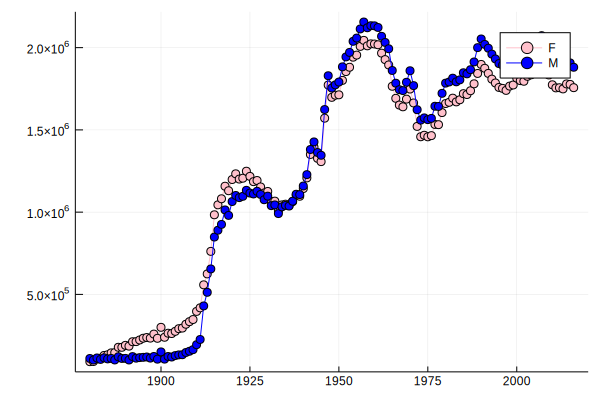

In [5]:
using StatsPlots

name_counts_by_year = by(babynames, [:Year, :Sex], :Count => sum)
sort!(name_counts_by_year, :Year)
@df name_counts_by_year plot(:Year, :Count_sum, group=:Sex, colour = [:pink :blue], marker=:circle)

The meteoric rise in babies born in the years leading up to 1920 may seem suspicious. A sentence from the quote above helps explain:

> Note that many people born before 1937 never applied for a Social Security card, so their names are not included in our data. For others who did apply, our records may not show the place of birth, and again their names are not included in our data.

We can also see the [baby boomer period](https://www.wikiwand.com/en/Baby_boomers) quite clearly in the plot above.

### Inferring Sex From Name

Let's use this dataset to estimate the number of females and males in our class. As with our class roster, we begin by lowercasing the names:

In [6]:
babynames.Name = map(lowercase, babynames.Name)
babynames

,Name,Sex,Count,Year
,String,String,Int64,Int64
1,mary,F,9217,1884
2,anna,F,3860,1884
3,emma,F,2587,1884
4,elizabeth,F,2549,1884
5,minnie,F,2243,1884
⋮,⋮,⋮,⋮,⋮


Then, we count up how many male and female babies were born in total for each name:

In [13]:
sex_counts = by(babynames, [:Name, :Sex], :Count => sum)
sort!(sex_counts, :Name)

sex_counts.X1 = ifelse.(sex_counts.Sex .== "F", sex_counts.Count_sum, 0)
sex_counts.X2 = ifelse.(sex_counts.Sex .== "M", sex_counts.Count_sum, 0)

sex_counts = by(sex_counts, :Name, F = :X1 => sum, M = :X2 => sum)
sex_counts.All = map((x,y) -> x + y, sex_counts.F, sex_counts.M)

total = ["All" sum(sex_counts.F) sum(sex_counts.M) sum(sex_counts.All)]
push!(sex_counts, total)

sex_counts

,Name,F,M,All
,String,Int64,Int64,Int64
1,aaban,0,96,96
2,aabha,35,0,35
3,aabid,0,10,10
4,aabir,0,5,5
5,aabriella,26,0,26
⋮,⋮,⋮,⋮,⋮


To determine whether a name is more popular for male or female babies, we can compute the proportion of times the name was given to a female baby.

In [14]:
sex_counts.prop_female = map((x,y) -> x / y, sex_counts.F, sex_counts.All)
sex_counts

,Name,F,M,All,prop_female
,String,Int64,Int64,Int64,Float64
1,aaban,0,96,96,0.0
2,aabha,35,0,35,1.0
3,aabid,0,10,10,0.0
4,aabir,0,5,5,0.0
5,aabriella,26,0,26,1.0
⋮,⋮,⋮,⋮,⋮,⋮


We can then define a function that looks up the proportion of female names given a name.

In [15]:
function sex_from_name(name)
    if name in sex_counts.Name
        df = filter(row -> row.Name == name, sex_counts)
        return df.prop_female[1] > 0.5 ? "F" : "M"
    else
        return "Name not in dataset"
    end
end

sex_from_name("sam")

"M"

### Our First Widget

In this book, we include widgets that allow the reader to interact with functions defined in the book. The widget below displays the output of `sex_from_name` on a reader-provided name.

Try typing in the name "josephine" and see how the inferred sex changes as more characters are entered.

In [16]:
name_textbox = textbox(hint="Enter name"; value="sam")
display(name_textbox)
map(x -> sex_from_name(x), observe(name_textbox))

(div { className="field interact-widget" }
    (input { attributes=Dict{Any,Any}(:type => "text",Symbol("data-bind") => "value: value, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}") hint="Enter name" placeholder="" className="input " style=Dict{Any,Any}() }))

Observable{Any} with 0 listeners. Value:
"M"

We mark each name in our class roster with its most likely sex.

In [17]:
students[!, :Sex] = map(x -> sex_from_name(x), students.Name)
students

,Name,Role,Sex
,String,String,String
1,keeley,Student,F
2,john,Student,M
3,bryan,Student,M
4,kaylan,Student,F
5,sol,Student,M
⋮,⋮,⋮,⋮


Now it is easy to estimate how many male and female students we have:

In [18]:
using StatsBase
print(countmap(students.Sex))
#another option
print(by(students, :Sex, df -> size(df, 1)))

Dict("M" => 144,"Name not in dataset" => 43,"F" => 92)3×2 DataFrame
│ Row │ Sex                 │ x1    │
│     │ String              │ Int64 │
├─────┼─────────────────────┼───────┤
│ 1   │ F                   │ 92    │
│ 2   │ M                   │ 144   │
│ 3   │ Name not in dataset │ 43    │

### Inferring Age From Name

We can proceed in a similar way to estimate the age distribution of the class, mapping each name to its average age in the dataset.

In [19]:
avg_years = by(babynames, [:Name], :Year => mean)
sort!(avg_years, :Name)
avg_years

,Name,Year_mean
,String,Float64
1,aaban,2011.89
2,aabha,2013.6
3,aabid,2009.5
4,aabir,2016.0
5,aabriella,2013.25
⋮,⋮,⋮


As before, we define a function to lookup the average birth year using a given name. We've included a widget for the reader to try out some names. We suggest trying names that seem older (e.g. "Mary") and names that seem newer (e.g. "Beyonce").

In [20]:
function year_from_name(name)
    if name in avg_years.Name
        df = filter(row -> row.Name == name, avg_years)
        return df.Year_mean[1]
    else
        return missing
    end
end

# Generate input box for you to try some names out:
year_textbox = textbox(hint="Enter name"; value="fernando")
display(year_textbox)
map(x -> year_from_name(x), observe(year_textbox))

(div { className="field interact-widget" }
    (input { attributes=Dict{Any,Any}(:type => "text",Symbol("data-bind") => "value: value, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}") hint="Enter name" placeholder="" className="input " style=Dict{Any,Any}() }))

Observable{Any} with 0 listeners. Value:
1960.7127071823204

Now, we can mark each name in Data 100 with its inferred birth year.

In [21]:
students[!, :Year_mean] = map(x -> year_from_name(x), students.Name)
students

,Name,Role,Sex,Year_mean
,String,String,String,Float64⍰
1,keeley,Student,F,1986.68
2,john,Student,M,1948.0
3,bryan,Student,M,1962.68
4,kaylan,Student,F,1997.84
5,sol,Student,M,1959.71
⋮,⋮,⋮,⋮,⋮


Then, it is easy to plot the distribution of years:

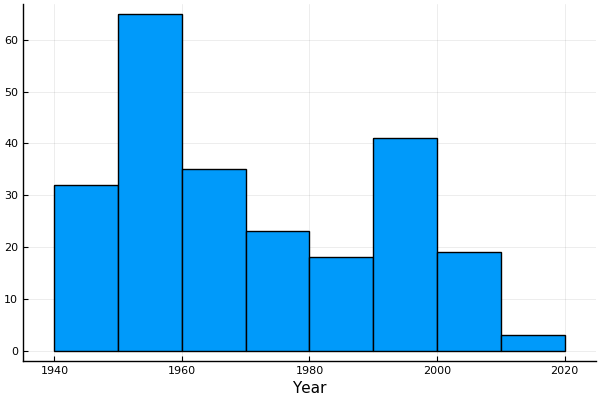

In [22]:
pyplot()
histogram(students.Year_mean, xaxis=("Year"), leg=false)

To compute the average year:

In [23]:
mean(skipmissing(students.Year_mean))

# for reference: dealing with missing values - https://docs.julialang.org/en/v1/manual/missing/

1971.1556272825674

Our class has an average age of 35 years old—nearly twice our expected age in a course for college undergraduates. Why might our estimate be so far off?

As data scientists, we often run into results that don't agree with our expectations. Our constant challenge is to determine whether surprising results are caused by an error in our procedure or by an actual, real-world phenomenon. Since there are no simple recipes to guarantee accurate conclusions, data scientists must equip themselves with guidelines and principles to reduce the likelihood of false discovery.

In this particular case, the most likely explanation for our unexpected result is that most common names have been used for many years. For example, the name John was quite popular throughout the history recorded in our data. We can confirm this by plotting the number of babies given the name "John" each year:

In [24]:
john_df = filter(row -> row.Name == "john" &&  row.Sex == "M", babynames)
sort!(john_df, :Year)

,Name,Sex,Count,Year
,String,String,Int64,Int64
1,john,M,9655,1880
2,john,M,8769,1881
3,john,M,9557,1882
4,john,M,8894,1883
5,john,M,9388,1884
⋮,⋮,⋮,⋮,⋮


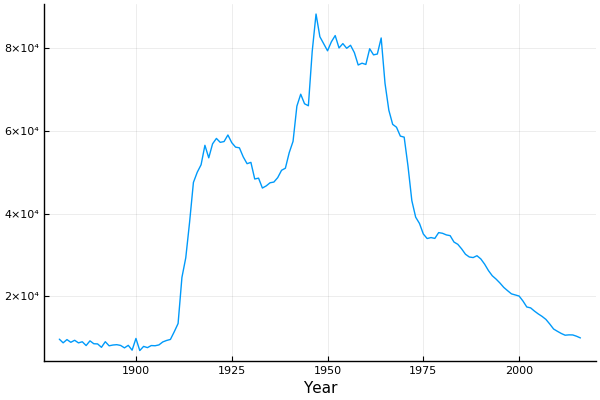

In [25]:
plot(john_df.Year, john_df.Count, xaxis="Year", leg=false)

It appears that the average birth year does not provide an accurate estimate for a given person's age in general. In a few cases, however, a person's first name is quite revealing!

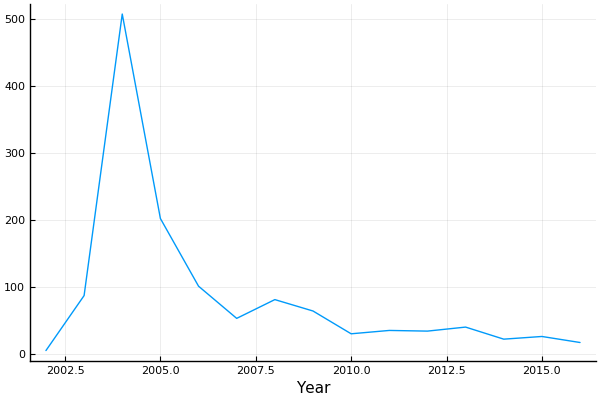

In [26]:
kanye_df = filter(row -> row.Name == "kanye" &&  row.Sex == "M", babynames)
sort!(kanye_df, :Year)
plot(kanye_df.Year, kanye_df.Count, xaxis=("Year"), leg=false)

## Summary

In this chapter, we walk through a complete iteration of the data science lifecycle: question formulation, data manipulation, exploratory data analysis, and prediction. We expand upon each of these steps in the following chapters.

The first half of the book (chapters 1-9) broadly covers the first three steps in the lifecycle and has a strong focus on computation. The second half of the book (chapters 10-18) uses both computational and statistical thinking to cover modeling, inference, and prediction.

As a whole, this book hopes to impart the reader with the principles and techniques of data science.